In [1]:
%load_ext autoreload
%env CUDA_VISIBLE_DEVICES=1
import sys
sys.path.append('..')

env: CUDA_VISIBLE_DEVICES=1


In [2]:
%autoreload
from graph_augmented_pt.utils.tensorboard_utils import *

from graphlet_atlas import *
from structural_synthetic_datasets import *
from synthetic_runner import *

import matplotlib, pandas as pd
%matplotlib inline

import copy, json, logging, os, pickle, shutil, time
from pathlib import Path
from IPython.display import Image 

# Generating Synthetic Data
## Graphlet Atlases

In [3]:
atlas4, atlas5, atlas6 = [GraphletAtlas.connected_graphs_up_to(i) for i in (4, 5, 6)]

Graphlet atlas contains 9 subgraphs of up to 4 nodes:


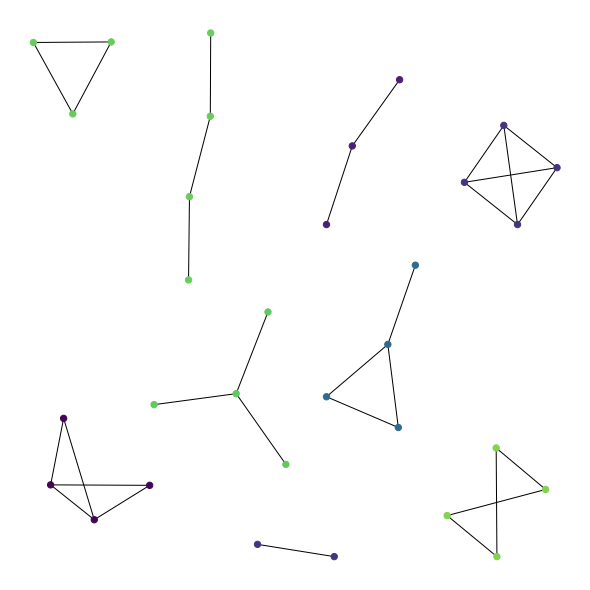

In [4]:
atlas4.display()

Graphlet atlas contains 30 subgraphs of up to 5 nodes:


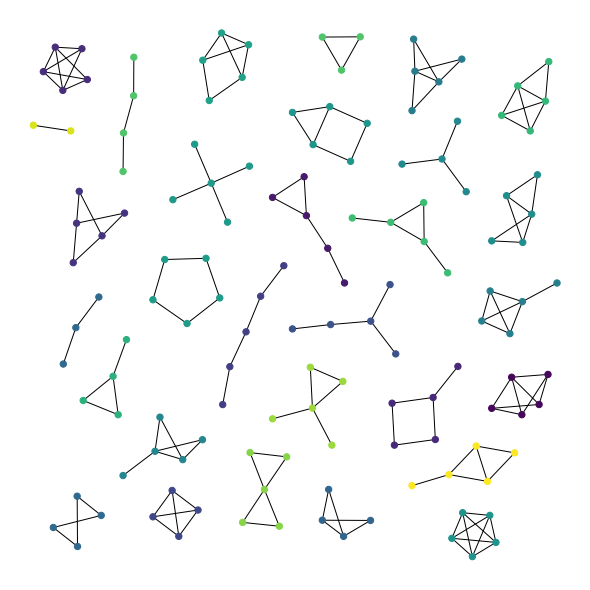

In [5]:
atlas5.display()

Graphlet atlas contains 138 subgraphs of up to 6 nodes:


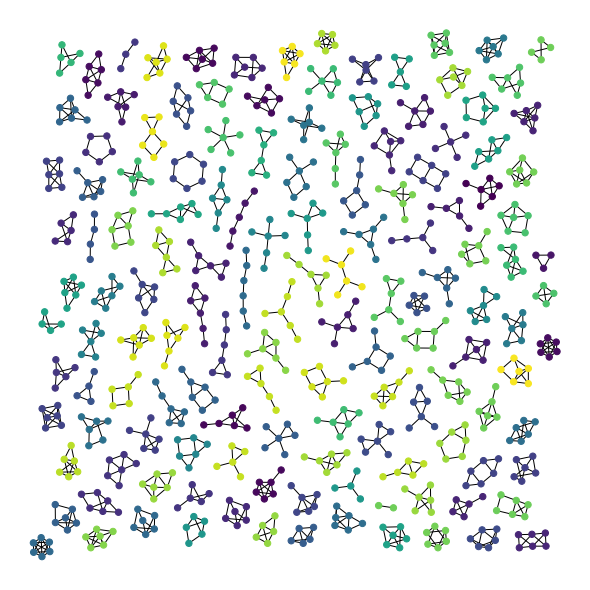

In [6]:
atlas6.display()

### Using Real Text
This version uses real text, clustered via LDA, to assign features to the nodes.

In [7]:
RAW_FILEPATH = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2.txt'
PKL_FILEPATH = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2_feat.pkl'

assert os.path.isfile(RAW_FILEPATH)
assert os.path.isfile(PKL_FILEPATH)

# Source: https://www.kaggle.com/mikeortman/wikipedia-sentences
with open(RAW_FILEPATH, mode='r') as f: text_data = f.readlines()

with open(PKL_FILEPATH, mode='rb') as f:
    X, LDA, topics, first_topic, sents_by_topic, topic_correlations = pickle.load(f)

In [8]:
synthetic_dataset = ClusteredSentencesSyntheticDataset(
    graphlet_atlas       = atlas5,
    base_cycle_size      = 9,
    num_graphlets        = 3,
    adjoining_graphlets  = ["random"], # w/in graphlet_atlas
    structural_atlas     = atlas4,
    sentences            = text_data,
    topic_probabilities  = topics,
)

graph has 24 nodes with 31 edges
Node Features:
0: Les Rosiers-sur-Loire is a former commune in the Maine-et-Loire department in the Pays de la Loire Region in western France.
1: It primarily provides news and information about the music business, music media and music world.
2: Candlewicking, or Candlewick is a form of whitework embroidery that traditionally uses an unbleached cotton thread on a piece of unbleached muslin.
3: In the Whyte notation for the classification of steam locomotives by wheel arrangement, a 2-8-8-0 is a locomotive with a two-wheel leading truck, two sets of eight driving wheels, and no trailing truck.
4: An 0-8-6, in the Whyte notation for the classification of steam locomotives by wheel arrangement, is a locomotive with no leading wheels, eight driving wheels (4 axles) fixed in a rigid frame, and six trailing wheels (normally mounted in a trailing truck).
5: The tattoo's meaning also can change depending on whether the tear is empty or is filled with ink.
6: U

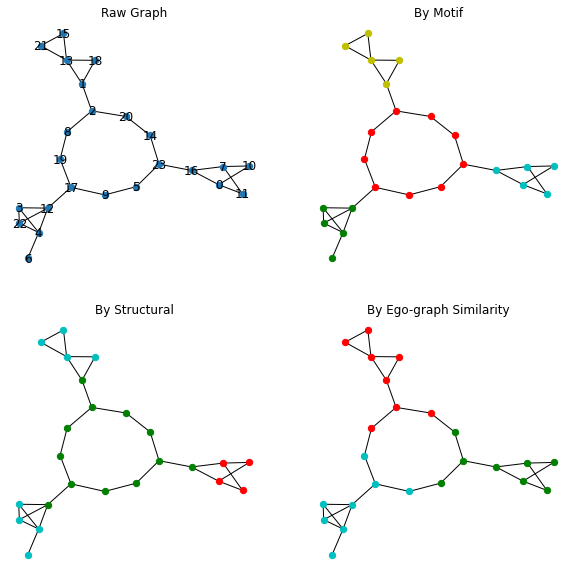

In [9]:
synthetic_dataset.display()

In [10]:
np.array(synthetic_dataset.vocab)

array(['[PAD]', '[MASK]', '[CLS]', 'w', '-', 'd', 'e', 'W', '0', '6', 'm',
       'h', 'T', "'", 'n', 'j', '8', ')', '(', '3', 'c', 'M', 'u', 'k',
       'H', '.', 'A', 'b', 'o', 'r', 'F', 'C', 'a', 'l', 'g', 'i', 'U',
       'L', 'R', 'z', 's', 'P', ',', 'I', '4', 'x', 'v', 'S', 't', 'y',
       '/', 'B', 'J', 'p', ' ', '2', 'f'], dtype='<U6')

## Run Experiments

In [11]:
output_dir_base = Path("/crimea/graph_augmented_pt/runs/synthetic_reproductions/structural")
if not output_dir_base.exists(): os.makedirs(output_dir_base)

datasets_filepath = output_dir_base / "datasets.pkl"

In [12]:
if datasets_filepath.exists():
    with open(datasets_filepath, mode='rb') as f: datasets = pickle.load(f)
else: datasets = {}

In [27]:
# node_assignments = [(task, f"clustered_by_{task.lower()}") for task in synthetic_dataset.label_sets.keys()]
# node_assignments.append((None, "generative"))
node_assignments = [
    ('Motif', 'clustered_by_motif'),
    ('Structural', 'clustered_by_structural'),
    ('Ego-graph Similarity', 'clustered_by_ego-graph similarity'),
]

graph_gen_kwargs = dict(
    graphlet_atlas             = atlas6,
    base_cycle_size            = 36,
    num_graphlets              = 9,
    adjoining_graphlets        = ["random"], # w/in graphlet_atlas
    structural_atlas           = atlas5,
    batch_size                 = 'ALL',
    neighborhood_labels_radius = 4,
    n_neighborhood_labels      = 4,
    seed                       = 0,
    num_dataloader_workers     = None,
)
cluster_assignment_nodes_kwargs = dict(
    sentences           = text_data,
    topic_probabilities = topics,
)
generative_nodes_kwargs = dict(
    node_id_strs_len  = 3,
    motif_id_strs_len = 6,
)

In [14]:
for gml_weight in tqdm((0.1, 0), desc="GML Weight", leave=False):
    for task, na in tqdm(node_assignments, desc="Node Featurizations", leave=False):
        for gml_head in tqdm((EUCLIDEAN_DISTANCE,), desc="GML Head", leave=False):
            if (gml_weight, task, gml_head) in datasets:
                print(f"Skipping {(gml_weight, task, gml_head)} as already done")
                continue
                
            output_dir = output_dir_base / gml_head / na / f"gml_weight_{gml_weight}"

            if os.path.isdir(output_dir):
                results_filepath = output_dir / "run_stats.json"
                if results_filepath.exists():
                    print(
                        f"Skipping {(gml_weight, task, gml_head)} as run already done "
                        "though dataset unsaved."
                    )
                    continue

            print(f"Making {(gml_weight, task, gml_head)} from scratch.")
            st = time.time()
            try:
                if task is None:
                    dataset = GenerativeNodesSyntheticDataset(
                        **graph_gen_kwargs,
                        **generative_nodes_kwargs,
                    ) 
                else:
                    dataset = ClusteredSentencesSyntheticDataset(
                        **graph_gen_kwargs,
                        **cluster_assignment_nodes_kwargs,
                        node_features_correspond_to_label=task,
                    )
                took = time.time() - st
                print(f"Took: {took}")

            except AssertionError as e:
                print(gml_weight, gml_head, na)
                raise
                    
            datasets[(gml_weight, task, gml_head)] = dataset          

Skipping (0.1, 'Ego-graph Similarity', 'euclidean') as already done


Skipping (0, 'Ego-graph Similarity', 'euclidean') as already done


In [15]:
with open(datasets_filepath, mode='wb') as f: datsaets = pickle.dump(datasets, f)

In [15]:
results = {}
times   = {}

logging.getLogger('lightning').setLevel(logging.ERROR)
DO_OVERWRITE = False

for task, na in tqdm(node_assignments, desc="Node Featurizations", leave=False):
    for gml_weight in tqdm((0.1, 0), desc="GML Weight"):
        point_weight = 1 - gml_weight
        for gml_head in tqdm((EUCLIDEAN_DISTANCE, ), desc="GML Head", leave=False):
            
            if gml_weight == 0 and gml_head != EUCLIDEAN_DISTANCE: continue
                
            times = [("Start", time.time())]
            
            output_dir = output_dir_base / gml_head / na / f"gml_weight_{gml_weight}"
            
            if os.path.isdir(output_dir):
                results_filepath = output_dir / "run_stats.json"
                if results_filepath.exists():
                    with open(results_filepath, mode='r') as f:
                        results[(gml_head, gml_weight, na)] = (json.loads(f.read()), None)
                    continue
                
                if DO_OVERWRITE: 
                    print(f"Overwriting {output_dir}")
                    shutil.rmtree(output_dir)
            else: os.makedirs(output_dir)
            
            times.append(("Directories Done", time.time()))
           
            dataset = datasets[(gml_weight, task, gml_head)]
            dataset.num_dataloader_workers = 0 # For synthetic data, this is way faster.
                
            times.append(("Dataset Made", time.time()))

            accum, models, model_metadata, dataset_seeds = run_synthetic(
                output_dir                    = output_dir,
                synthetic_dataset             = dataset,
                gml_head                      = gml_head,
                gml_weight                    = gml_weight,
                point_weight                  = point_weight,
                print_first                   = 0,
                do_plot                       = False,
                tqdm                          = lambda *args, **kwargs: tqdm(*args, **kwargs, leave=False),
                num_epochs                    = 5000,
                num_samples                   = 3,
                re_gen_data_in_between        = True,
                neighbor_prediction_eval_freq = 100,
                save_freq                     = 0,
                weights_summary               = None,
                do_checkpointing              = False,
                progress_bar_refresh_rate     = 0,
                do_overwrite                  = DO_OVERWRITE,
            )
            
            times.append(("Run Complete", time.time()))
            
            res_dict = {k: accum.mean_std(k) for k in accum.run_stats}
            
            with open(output_dir / "run_stats.json", mode='w') as f:
                f.write(json.dumps(res_dict, indent=2))
                            
            times.append(("End", time.time()))
            results[(gml_head, gml_weight, na)] = (res_dict, times)

/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


## Plotting Results

### Fetching Results

In [28]:
results = {}
mlm_key = 'Train/accuracy_masked_epoch'

for task, na in tqdm(node_assignments, desc="Node Featurizations", leave=False):
    for gml_weight in tqdm((0, 0.1), desc="GML Weight"):
        for gml_head in tqdm((EUCLIDEAN_DISTANCE,), desc="GML Head", leave=False):                
            run_dir = output_dir_base / gml_head / na / f"gml_weight_{gml_weight}"
            results_filepath = run_dir / "run_stats.json"
            
            if not results_filepath.exists(): continue
                
            with open(results_filepath, mode='r') as f:
                results[(gml_head, gml_weight, na)] = (json.loads(f.read()), None)
            
            samples = [d for d in os.listdir(run_dir) if d != 'run_stats.json']
            final_mlm_accs = []
            for sample in tqdm(samples, desc="Samples", leave=False):
                summary_dir = run_dir / sample / "lightning_logs" / "version_0"
                
                summary_filename = next(fn for fn in os.listdir(summary_dir) if fn != 'hparams.yaml')
                
                summary_filepath = summary_dir / summary_filename
                assert summary_filepath.exists()
                
                _, event_streams, steps, times = read_tensorboard_log(summary_filepath)
                if steps[mlm_key]:
                    idx = np.argmax(steps[mlm_key])
                    final_mlm_accs.append(event_streams[mlm_key][idx])
                else: final_mlm_accs.append(np.NaN)
            
            results[(gml_head, gml_weight, na)][0]['MLM (masked) Accuracy'] = (
                np.mean(final_mlm_accs), np.std(final_mlm_accs)
            )

In [29]:
results[next(iter(results))]

({'labels/Motif Accuracy': [0.5442789968652038, 0.10538105699201572],
  'labels/Motif AUROC': [0.7251792895969991, 0.03636387869347622],
  'labels/Structural Accuracy': [0.5785324509462441, 0.08700905380981525],
  'labels/Structural AUROC': [0.661795436005185, 0.05050062490071594],
  'labels/Ego-graph Similarity Accuracy': [0.399587832346453,
   0.04684346399700984],
  'labels/Ego-graph Similarity AUROC': [0.6432635848445153,
   0.0364677420447375],
  'MLM (masked) Accuracy': (0.26902685562769574, 0.0687833289962729)},
 None)

In [30]:
# Strip the labels/ prefix for all task keys.
for k, v in results.items():
    results[k] = ({vk.strip('labels/'): vv for vk, vv in v[0].items()}, None)

In [31]:
results[next(iter(results))]

({'Motif Accuracy': [0.5442789968652038, 0.10538105699201572],
  'Motif AUROC': [0.7251792895969991, 0.03636387869347622],
  'Structural Accuracy': [0.5785324509462441, 0.08700905380981525],
  'Structural AUROC': [0.661795436005185, 0.05050062490071594],
  'Ego-graph Similarity Accuracy': [0.399587832346453, 0.04684346399700984],
  'Ego-graph Similarity AUROC': [0.6432635848445153, 0.0364677420447375],
  'MLM (masked) Accuracy': (0.26902685562769574, 0.0687833289962729)},
 None)

In [32]:
flat_dict = {}
tasks = None
for k, (res_dict, times) in results.items():
    if tasks is None: tasks = list(res_dict.keys())
    mean_col = [res_dict[t][0] for t in tasks]
    std_col = [res_dict[t][1] for t in tasks]

    flat_dict[tuple(list(k) + ['mean'])] = mean_col
    flat_dict[tuple(list(k) + ['std'])] = std_col
        
results_df = pd.DataFrame(flat_dict)
results_df.columns.names = ['GML Head', 'w_rel', 'Node Assignment Strategy', 'Aggregation']
results_df.index = pd.MultiIndex.from_tuples(
    [(t[:t.rfind(' ')], t[t.rfind(' ')+1:]) for t in tasks], names = ['Task', 'Performance Metric']
)

In [33]:
results_df

GML Head                                         euclidean            \
w_rel                                                  0.0             
Node Assignment Strategy                clustered_by_motif             
Aggregation                                           mean       std   
Task                 Performance Metric                                
Motif                Accuracy                     0.544279  0.105381   
                     AUROC                        0.725179  0.036364   
Structural           Accuracy                     0.578532  0.087009   
                     AUROC                        0.661795  0.050501   
Ego-graph Similarity Accuracy                     0.399588  0.046843   
                     AUROC                        0.643264  0.036468   
MLM (masked)         Accuracy                     0.269027  0.068783   

GML Head                                                              \
w_rel                                                  0.1             
Node Assignment Strategy                clustered_by_motif             
Aggregation                                           mean       std   
Task                 Performance Metric                                
Motif                Accuracy                     0.720083  0.076034   
                     AUROC                        0.883933  0.037334   
Structural           Accuracy                     0.663459  0.051076   
                     AUROC                        0.690416  0.037578   
Ego-graph Similarity Accuracy                     0.554270  0.051545   
                     AUROC                        0.760317  0.049728   
MLM (masked)         Accuracy                     0.265873  0.066191   

GML Head                                                                   \
w_rel                                                       0.0             
Node Assignment Strategy                clustered_by_structural             
Aggregation                                                mean       std   
Task                 Performance Metric                                     
Motif                Accuracy                          0.411755  0.031947   
                     AUROC                             0.601296  0.034669   
Structural           Accuracy                          0.829981  0.038200   
                     AUROC                             0.904796  0.010717   
Ego-graph Similarity Accuracy                          0.313340  0.009550   
                     AUROC                             0.556268  0.014138   
MLM (masked)         Accuracy                          0.228241  0.020427   

GML Head                                                                   \
w_rel                                                       0.1             
Node Assignment Strategy                clustered_by_structural             
Aggregation                                                mean       std   
Task                 Performance Metric                                     
Motif                Accuracy                          0.565514  0.040177   
                     AUROC                             0.740630  0.043993   
Structural           Accuracy                          0.799721  0.025181   
                     AUROC                             0.789544  0.035047   
Ego-graph Similarity Accuracy                          0.422434  0.068458   
                     AUROC                             0.642595  0.084320   
MLM (masked)         Accuracy                          0.232801  0.031614   

GML Head                                                                   \
w_rel                                                                 0.0   
Node Assignment Strategy                clustered_by_ego-graph similarity   
Aggregation                                                          mean   
Task                 Performance Metric                                     
Motif                Accuracy      

In [36]:
LINESTYLES = {
    EUCLIDEAN_DISTANCE: '-'
}
TASK_COLORS = {
#     'MLM (masked)': 'blue',
    'Motif': 'red',
    'Structural': 'green',
    'Ego-graph Similarity': 'purple',
}

def plot(
    node_assignments=node_assignments, heads=(EUCLIDEAN_DISTANCE,), tasks='ALL'
):
    W = math.ceil(math.sqrt(len(node_assignments)))
    H = math.ceil(len(node_assignments) / W)

    fig, axes = plt.subplots(nrows=H, ncols=W, figsize = (7*W, 7*H))
    flat_axes = list(itertools.chain.from_iterable(axes))
    
    if tasks == 'ALL': tasks = TASK_COLORS.keys()
    if type(heads) is str: heads = [heads]

    for (task, na), ax in zip(node_assignments, flat_axes):
        title = na.replace('_', ' ').title()
        ax.set_title(title, fontsize=32)
        ax.set_xlabel("$\lambda_{rel}$", fontsize=16)
        ax.set_ylabel("AUROC", fontsize=16)
        mlm_acc_ax = ax.twinx()
        mlm_acc_ax.set_ylabel("MLM Accuracy", fontsize=16)

        for gml_head in heads:
            idx = pd.IndexSlice
            try:
                rest_df = results_df.loc[:, idx[gml_head, :, na, :]]
                rest_df.columns = rest_df.columns.droplevel((0, 2))
            except KeyError:
                print(f"{na}, {gml_head} not started.")
                continue

            X = sorted(list(set(rest_df.columns.get_level_values('w_rel'))))
            for task in set(rest_df.index.get_level_values('Task')):
                if task not in tasks: 
                    continue
                    
                if task == 'MLM (masked)':
                    plt_ax = mlm_acc_ax
                    perf_metric = 'Accuracy'
                else:
                    plt_ax = ax
                    perf_metric = 'AUROC'
                    
                means = rest_df.loc[(task, perf_metric), idx[X, 'mean']].values
                stds = rest_df.loc[(task, perf_metric), idx[X, 'std']].values

                plt_ax.plot(X, means, linestyle=LINESTYLES[gml_head], color=TASK_COLORS[task], label=task)
                plt_ax.fill_between(X, means - stds, means + stds, color=TASK_COLORS[task], alpha=0.1)

    for ax in flat_axes[len(node_assignments):]: ax.set_axis_off()


    handles, labels = [], []
    for task in tasks:
        label = task
        handles.append(mlines.Line2D(
            [], [], color=TASK_COLORS[task], label=label, linestyle='-'
        ))
        labels.append(label)
        
    if len(heads) > 1:
        for head in heads:
            label = head
            handles.append(mlines.Line2D(
                [], [], color='black', label=label, linestyle=LINESTYLES[head]
            ))
            labels.append(label)
        
    flat_axes[-1].legend(handles = handles, labels = labels, fontsize=14)
    
    fig.tight_layout()

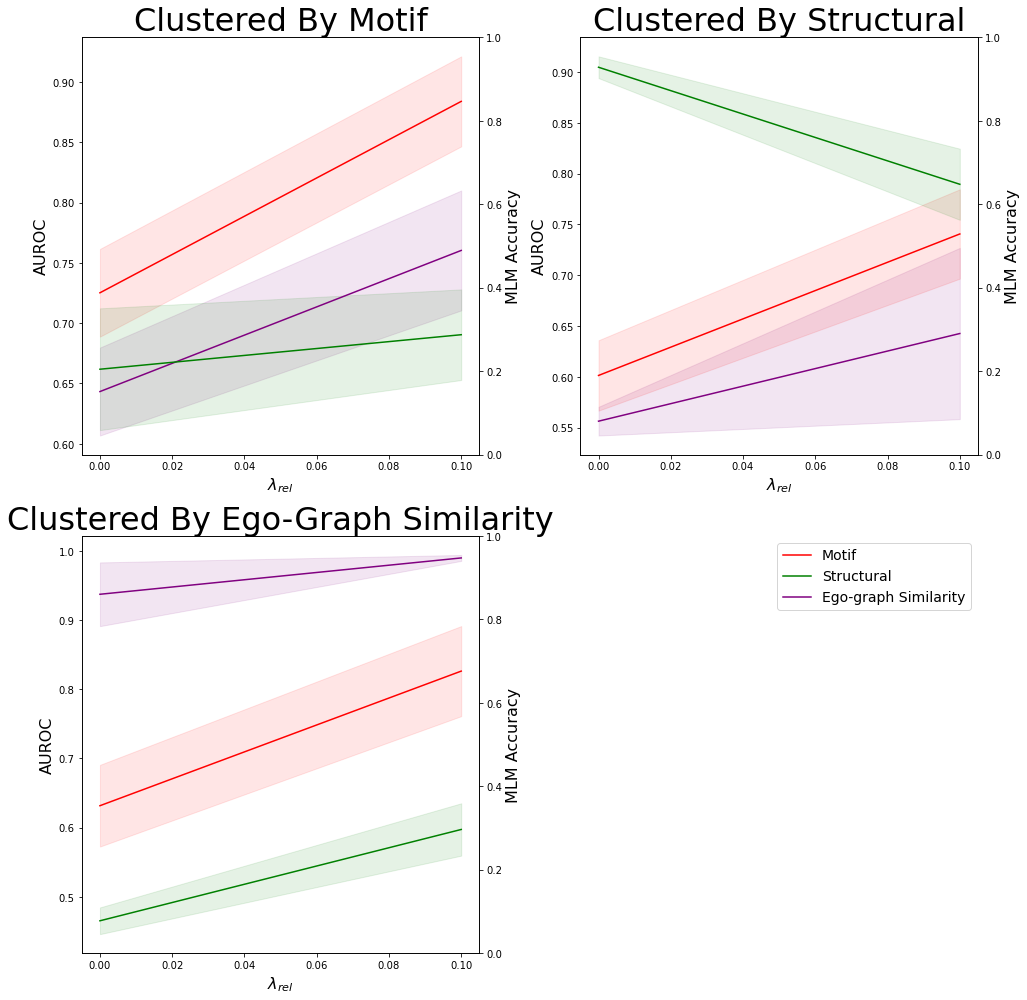

In [37]:
plot(
    node_assignments = node_assignments,
    heads=EUCLIDEAN_DISTANCE
)

In [38]:
tasks

['Motif Accuracy',
 'Motif AUROC',
 'Structural Accuracy',
 'Structural AUROC',
 'Ego-graph Similarity Accuracy',
 'Ego-graph Similarity AUROC',
 'MLM (masked) Accuracy']

In [39]:
def plot_aligned(
    node_assignments=node_assignments, heads=(EUCLIDEAN_DISTANCE,), tasks='ALL'
):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    if type(heads) is str: heads = [heads]
        
    ax.set_title("Embedding Alignment after Graph Guided PT")
    ax.set_xlabel("$\lambda_{rel}$", fontsize=16)
    ax.set_ylabel("AUROC", fontsize=16)

    tasks = []
    for task, na in node_assignments:
        if task == None: continue
        for gml_head in heads:
            idx = pd.IndexSlice
            try:
                rest_df = results_df.loc[:, idx[gml_head, :, na, :]]
                rest_df.columns = rest_df.columns.droplevel((0, 2))
            except KeyError:
                print(f"{na}, {gml_head} not started.")
                continue

            X = sorted(list(set(rest_df.columns.get_level_values('w_rel'))))
                    
            perf_metric = 'AUROC'

            try:
                means = rest_df.loc[(task, perf_metric), idx[X, 'mean']].values
                stds = rest_df.loc[(task, perf_metric), idx[X, 'std']].values
            except KeyError as e:
                display(rest_df)
                print(task, perf_metric, X)
                raise

            ax.plot(X, means, linestyle=LINESTYLES[gml_head], color=TASK_COLORS[task], label=task)
            ax.fill_between(X, means - stds, means + stds, color=TASK_COLORS[task], alpha=0.1)
            tasks.append(task)

    handles, labels = [], []
    for task in tasks:
        label = task
        handles.append(mlines.Line2D(
            [], [], color=TASK_COLORS[task], label=label, linestyle='-'
        ))
        labels.append(label)
        
    if len(heads) > 1:
        for head in heads:
            label = head
            handles.append(mlines.Line2D(
                [], [], color='black', label=label, linestyle=LINESTYLES[head]
            ))
            labels.append(label)
        
    ax.legend(handles = handles, labels = labels, fontsize=14, loc="lower center", bbox_to_anchor=(0.5, -0.3))
    
    fig.tight_layout()

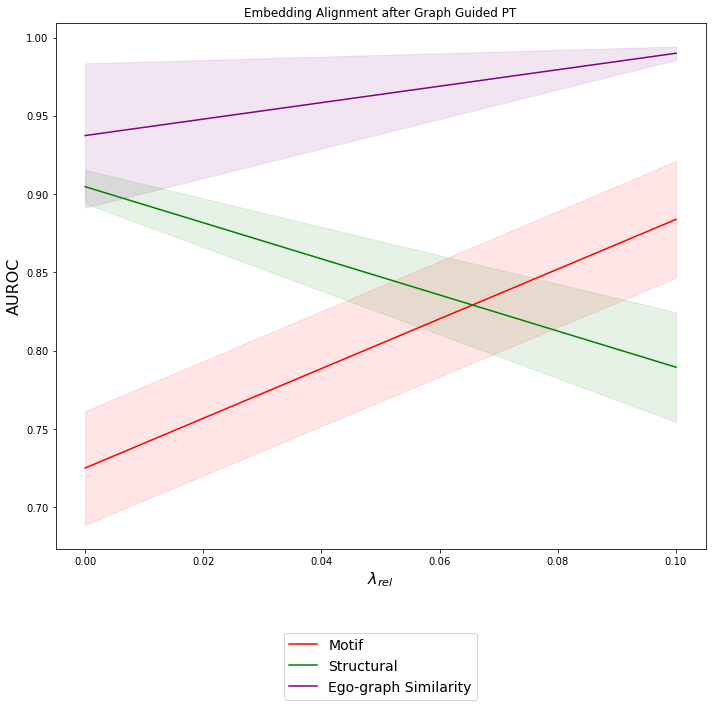

In [40]:
plot_aligned(
    node_assignments = node_assignments,
    heads=EUCLIDEAN_DISTANCE
)